In [1]:
import json
import pandas as pd
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import *
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import easydict
import sys
import re
import six
import math
import torchvision.transforms as transforms

sys.path.append('./Whatiswrong')
sys.path.append('./Scatter')
import scatter_utils
import utils
import scatter_model_jamo
import en_dataset
import ko_dataset
import augs
import albumentations
from albumentations import GaussNoise, IAAAdditiveGaussianNoise, Compose, OneOf
from albumentations.pytorch import ToTensor
import pickle

In [2]:
import importlib
importlib.reload(scatter_model_jamo)

<module 'scatter_model_jamo' from './Scatter/scatter_model_jamo.py'>

In [3]:
# opt
opt = easydict.EasyDict({
    "experiment_name" : f'{utils.SaveDir_maker("scatter_jamo", "./models")}',
    'saved_model' : '',
    "imgH" : 35 ,"imgW" :  90,  'batch_size' : 384, 
    'top_char' : ' !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㄲㄸㅃㅆㅉ',
    'mid_char' : ' ㅏㅑㅓㅕㅗㅛㅜㅠㅡㅣㅐㅒㅔㅖㅘㅙㅚㅝㅞㅟㅢ',
    'bot_char' : ' ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㄲㄸㅃㅆㅉㄳㄵㄶㄺㄻㄼㄽㄾㄿㅀㅄ',
    'batch_max_length' : 25,
    'output_channel' : 512, 'hidden_size' :256,
    'valinterval' : 500, 'num_epoch' : 10, 'input_channel' : 3,
    'n_scrb' : 2, 'scr_loss_lambda' : 1, 'ctc_loss_lambda' : 0.1,
    'lr' : 1, 'rho' : 0.95, 'eps' : 1e-8,
    'grad_clip' : 5,
    "manualSeed" : 1111, "PAD" : True ,'data_filtering_off' : True,'rgb' :True,'sensitive' : True, 'FT' : True,
    'num_fiducial' : 20,
    'extract' : 'resnet',
#     'scr_n_blocks' : 5
    })
top_converter = utils.AttnLabelConverter(opt.top_char)
mid_converter = utils.AttnLabelConverter(opt.mid_char)
bot_converter = utils.AttnLabelConverter(opt.bot_char)
opt.top_n_cls = top_converter.n_cls
opt.mid_n_cls = mid_converter.n_cls
opt.bot_n_cls = bot_converter.n_cls
device = torch.device('cuda') #utils.py 안에 device는 따로 세팅해줘야함
# device = torch.device('cpu')

In [4]:
# # KOREAN
# data=[]
# ko_hand = ko_dataset.hand_dataset( dataset_mode = 'word', label_mode = 'jamo') 
# ko_public = ko_dataset.public_crop(mode = 'jamo') 
# ko_synthetic = ko_dataset.korean_synthetic(need_samples = 2500000, mode='jamo')
# ko_synthetic_long = ko_dataset.korean_synthetic_long(mode='jamo')

# # ENGLISH 
# eng_dataset = en_dataset.get_english_dataset(mode='jamo')
# eng_synthetic = en_dataset.en_synthetic(mode='jamo', need_samples= 3500000) #0 for all

In [5]:
# # """ Seed setting """
# # # print("Random Seed: ", opt.manualSeed)
# random.seed(opt.manualSeed)
# np.random.seed(opt.manualSeed)
# torch.manual_seed(opt.manualSeed)
# torch.cuda.manual_seed(opt.manualSeed)

# data.extend(ko_hand.dataset)
# data.extend(ko_public.dataset)
# data.extend(ko_synthetic.dataset)
# data.extend(ko_synthetic_long.dataset)
# data.extend(eng_dataset)
# data.extend(eng_synthetic.dataset)
# random.shuffle(data)
# print('Total number of data : ', len(data))

In [5]:
with open('./dataset_180_light2', 'rb') as file:
    data = pickle.load(file)

In [6]:
transformers = Compose([
                        OneOf([
#                                   augs.VinylShining(1),
                            augs.GridMask(num_grid=(10,20)),
                            augs.RandomAugMix(severity=1, width=1)], p =0.7),
                            ToTensor()
                       ])
train_custom = utils.CustomDataset_jamo(data[ : int(len(data) * 0.98)], resize_shape = (opt.imgH, opt.imgW), transformer=transformers)
valid_custom = utils.CustomDataset_jamo(data[ int(len(data) * 0.98): ], resize_shape = (opt.imgH, opt.imgW), transformer=ToTensor())

data_loader = DataLoader(train_custom, batch_size = opt.batch_size,  num_workers = 15, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(valid_custom, batch_size = opt.batch_size,  num_workers= 15, shuffle=True,  drop_last=True, pin_memory=True )

# train

In [7]:
def train(opt):
    
    model = scatter_model_jamo.SCATTER(opt, device)

    # CHECK PRETRAINED MODEL
    if opt.saved_model!='':
        base_path = './models'
        try:
            if opt.FT:
                model.load_state_dict(torch.load(os.path.join(base_path, opt.saved_model)), strict=False)
            else :
                model.load_state_dict(torch.load(os.path.join(base_path, opt.saved_model)))
            print('got your model!')
        except Exception as e:
            print(f'Coudnt load model. error is {e}')
    # Multi GPU        
    model = torch.nn.DataParallel(model).to(device)
    model.train()
       
    # LOSS 
    scr_criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)
    ctc_criterion = torch.nn.CTCLoss(blank= 0, zero_infinity=True).to(device)
    
    # Filter only require gradient descent
    filtered_params = []
    params_num = []
    for p in filter(lambda p : p.requires_grad, model.parameters()):
        filtered_params.append(p)
        params_num.append(np.prod(p.size()))
    print('Trainable params : ', sum(params_num))
    
    # OPTIMIZER
    optimizer = optim.Adadelta(filtered_params, lr= opt.lr, rho = opt.rho, eps = opt.eps)
#     optimizer = optim.Adam(filtered_params)

    # OPT LOG
    with open(f'./models/{opt.experiment_name}/opt.txt', 'a') as opt_file:
        opt_log = '-----------------Options--------------------\n'
        args = vars(opt)
        for k, v in args.items():
            opt_log +=f'{str(k)} : {str(v)}\n'
        opt_log+= '--------------------------------------------\n' 
        opt_file.write(opt_log)
        
    # START TRAIN
    start_time = time.time()
    best_accuracy = -1
    best_norm_ED = -1
    
    for n_epoch, epoch in enumerate(range(opt.num_epoch)):
        for n_iter, data_point in enumerate(data_loader):
            images, top, mid, bot = data_point
            images = images.to(device)

            text_top, length_top = top_converter.encode(top, batch_max_length = opt.batch_max_length)
            text_mid, length_mid = mid_converter.encode(mid, batch_max_length = opt.batch_max_length)
            text_bot, length_bot = bot_converter.encode(bot, batch_max_length = opt.batch_max_length)
            batch_size = images.size(0)
            
            # Logits
            top_prob_list, mid_prob_list, bot_prob_list = model(images, text_top[:, :-1], text_mid[:, :-1], text_bot[:,:-1], is_train=True)
            
            top_ctc_prob = top_prob_list[0].permute(1,0,2)
            mid_ctc_prob = mid_prob_list[0].permute(1,0,2)
            bot_ctc_prob = bot_prob_list[0].permute(1,0,2)

            # Loss 
            losses = []
            input_lengths_top = torch.IntTensor([top_ctc_prob.size(0)] * batch_size)
            input_lengths_mid = torch.IntTensor([mid_ctc_prob.size(0)] * batch_size)
            input_lengths_bot = torch.IntTensor([bot_ctc_prob.size(0)] * batch_size)
            ctc_loss_top = ctc_criterion(top_ctc_prob, text_top[:, 1:] , input_lengths_top, length_top)
            ctc_loss_mid = ctc_criterion(mid_ctc_prob, text_mid[:, 1:],  input_lengths_mid, length_mid)
            ctc_loss_top = ctc_criterion(bot_ctc_prob, text_bot[:, 1:] , input_lengths_bot, length_bot)
            
            losses.append(opt.ctc_loss_lambda * ctc_loss_top)
            losses.append(opt.ctc_loss_lambda * ctc_loss_mid)
            losses.append(opt.ctc_loss_lambda * ctc_loss_top)

            for prob_list, text in zip([top_prob_list, mid_prob_list, bot_prob_list], [text_top, text_mid, text_bot]):
                for prob in prob_list[1:]:
                    scr_loss = scr_criterion(prob.view(-1, prob.shape[-1]), text[:, 1:].contiguous().view(-1))
                    losses.append(opt.scr_loss_lambda * scr_loss)

            loss=0
            loss_avg = utils.Averager()
            for loss_ in losses:
                loss = loss + loss_
                loss_avg.add(loss_)

            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), opt.grad_clip)
            optimizer.step()
#             print(loss_avg.val())

            #VALIDATION
            if (n_iter % opt.valinterval ==0) :
#                 & (n_iter!=0):
                elapsed_time = time.time() - start_time
                with open(f'./models/{opt.experiment_name}/log_train.txt' , 'a') as log:
                    model.eval()
                    with torch.no_grad():  #criterion arguments = ctc_criterion first
                        valid_loss, current_accuracy, current_norm_ED, top_pred_str, mid_pred_str, bot_pred_str,  confidence_score, top_label_str, mid_label_str, bot_label_str, infer_time, length_of_data = scatter_utils.validation_jamo(model, [ctc_criterion, scr_criterion], valid_loader, top_converter,mid_converter, bot_converter, opt, device)  
                    
                    model.train()
                    present_time = time.localtime()
                    loss_log = f'[epoch : {n_epoch}/{opt.num_epoch}] [iter : {n_iter*batch_size} / {int(len(data)*0.98)}]\n'+\
                    f'Train loss : {loss_avg.val():0.5f}, Valid loss : {valid_loss:0.5f}, Elapsed time : {elapsed_time:0.5f}, Present time : {present_time[1]}/{present_time[2]}, {present_time[3]} : {present_time[4]}'
                    loss_avg.reset()

                    current_model_log = f'{"Current_accuracy":17s}: {current_accuracy:0.3f}, {"current_norm_ED":17s}: {current_norm_ED:0.2f}'

                    #keep the best
                    if current_accuracy > best_accuracy:
                        best_accuracy = current_accuracy
                        torch.save(model.module.state_dict(), f'./models/{opt.experiment_name}/best_accuracy.pth')

                    if current_norm_ED > best_norm_ED:
                        best_norm_ED = current_norm_ED
                        torch.save(model.module.state_dict(), f'./models/{opt.experiment_name}/best_norm_ED.pth')

                    best_model_log = f'{"Best accuracy":17s}: {best_accuracy:0.3f}, {"Best_norm_ED":17s}: {best_norm_ED:0.2f}'
                    loss_model_log = f'{loss_log}\n{current_model_log}\n{best_model_log}'
                    print(loss_model_log)
                    log.write(loss_model_log+'\n')

                    dashed_line = '-'*80
                    head = f'{"Ground Truth":25s} | {"Prediction":25s}|Confidence Score & T/F'
                    predicted_result_log = f'{dashed_line}\n{head}\n{dashed_line}\n'
                    
                    random_idx  = np.random.choice(range(len(top_label_str)), size= 5, replace=False)
                    label_concat = np.concatenate([np.asarray(top_label_str).reshape(1,-1), np.asarray(mid_label_str).reshape(1,-1), np.asarray(bot_label_str).reshape(1,-1)], axis=0).reshape(3,-1)
                    pred_concat = np.concatenate([np.asarray(top_pred_str).reshape(1,-1), np.asarray(mid_pred_str).reshape(1,-1), np.asarray(bot_pred_str).reshape(1,-1)], axis=0).reshape(3,-1)
                    
#                     for gt, pred, confidence in zip(list(np.asarray(labels)[:5]), list(np.asarray(preds)[:5]), list(np.asarray(confidence_score)[:5])):
#                         gt = gt[: gt.find('[s]')]
#                         pred = pred[: pred.find('[s]')]

#                         predicted_result_log += f'{gt:25s} | {pred:25s} | {confidence:0.4f}\t{str(pred == gt)}\n'
                        
                    for i in random_idx:
                        label_sample = label_concat[:, i]
                        pred_sample = pred_concat[:, i]

                        gt_str = utils.str_combine(label_sample[0], label_sample[1], label_sample[2])
                        pred_str = utils.str_combine(pred_sample[0], pred_sample[1], pred_sample[2])
                        predicted_result_log += f'{gt_str:25s} | {pred_str:25s} | \t{str(pred_str == gt_str)}\n'
                        
                    predicted_result_log += f'{dashed_line}'
                    print(predicted_result_log)
                    log.write(predicted_result_log+'\n')

        if n_epoch % 5 ==0:
            torch.save(model.module.state_dict(), f'./models/{opt.experiment_name}/{n_epoch}.pth')
            

# main

In [ ]:
os.makedirs(f'./models/{opt.experiment_name}', exist_ok=True)

# set seed
random.seed(opt.manualSeed)
np.random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
torch.cuda.manual_seed(opt.manualSeed)

# set GPU
cudnn.benchmark = True
cudnn.deterministic = True
opt.num_gpu = torch.cuda.device_count()

# if opt.num_gpu > 1:
#     print('-------Use multi GPU setting-------')
#     opt.batch_size = opt.batch_size * opt.num_gpu
train(opt)

Trainable params :  184471613


## validation with visualization

In [12]:
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_location)
device = torch.device('cpu') 

class Valid_visualizer():
    def __init__(self, opt, model_path, val_path, visual_samples, device):
        self.opt = opt
        self.model_path = model_path
        self.val_path = val_path
        self.dataset = self._get_dataset()
        self.visual_samples = visual_samples
        self.device = device
        
    def _load_model(self):
        model = scatter_model.SCATTER(self.opt, self.device)
        model.load_state_dict(torch.load(self.model_path))
        model.to(self.device)
        model.eval()
        return model
    
    def _get_dataset(self):
        val_list = os.listdir(self.val_path)
        val_dataset = []
        label = 'ㄱ'
        for val in val_list:
#             img = Image.open(f'./val/{val}').convert('RGB')
            val_dataset.append(['./val/'+ val, label])
        return val_dataset
    
    def _get_valid_loader(self):

        test_streamer = utils.Dataset_streamer(self.dataset, resize_shape = (opt.imgH, opt.imgW))
#         _AlignCollate = utils.AlignCollate(imgH=self.opt.imgH, imgW=self.opt.imgW, keep_ratio_with_pad=True)
#         test_loader = DataLoader(test_streamer, batch_size = len(self.dataset), num_workers =0, collate_fn = _AlignCollate,)
        test_loader = DataLoader(test_streamer, batch_size = len(self.dataset), num_workers =0)
        return iter(test_loader)
    
    
    def valid_visualize(self):
        random.shuffle(self.dataset)
        test_loader_iter = self._get_valid_loader()
        image_tensor, label = next(test_loader_iter)
        model = self._load_model()
        output = model(input = image_tensor, text= ' ', is_train=False)
        pred_index = output[-1].max(2)[1]
        pred_length = torch.IntTensor([opt.batch_max_length] * len(self.dataset)).to(device)
        pred_decode = converter.decode(pred_index, pred_length)
        preds = []
        
        for pred in pred_decode:
            pred_temp = pred[ : pred.find('[s]')]
        #             pred_temp = join_jamos(pred_temp)
            preds.append(pred_temp)

              
        plt.figure(figsize=(50,80))
        for i in range(self.visual_samples):
            plt.subplot(1, len(self.dataset), i+1)
            plt.imshow(Image.open(self.dataset[i][0]))
            plt.xlabel(f'Prediction : {preds[i]}', fontproperties=fontprop, fontsize=20)
        plt.show()

In [13]:
vv = Valid_visualizer(opt, model_path = './models/scatter_0704/1/best_accuracy.pth', val_path = './val/', visual_samples = 8, device= device)

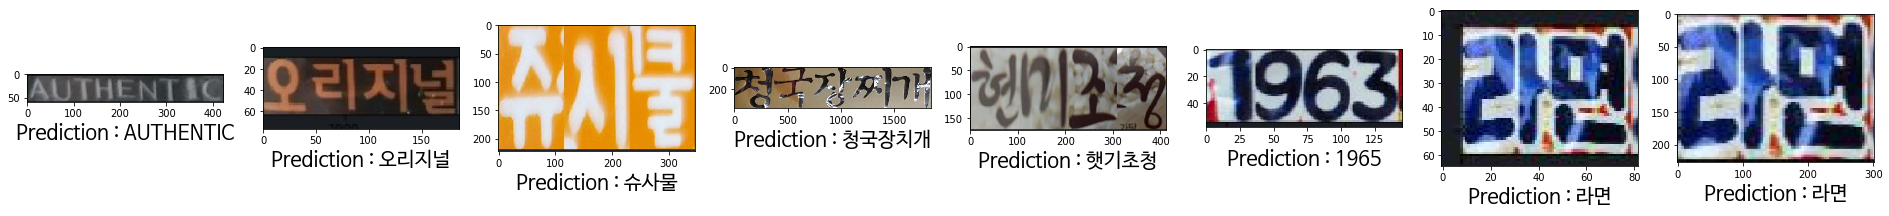

In [17]:
vv.valid_visualize()

In [38]:
import importlib
importlib.reload(scatter_model_jamo)

<module 'scatter_model_jamo' from './Scatter/scatter_model_jamo.py'>

In [40]:
device = torch.device('cuda') 
model = scatter_model_jamo.SCATTER(opt, device)
# model.load_state_dict(torch.load('./models/scatter_0620_syllable/first/best_accuracy.pth'))
model = torch.nn.DataParallel(model).to(device)
_ = model.train()

In [56]:
iterer = iter(data_loader)
img, top, mid, bot = next(iterer)

In [57]:
img.to(device)
text_top, length_top = top_converter.encode(top, batch_max_length = opt.batch_max_length)
text_mid, length_mid = mid_converter.encode(mid, batch_max_length = opt.batch_max_length)
text_bot, length_bot = bot_converter.encode(bot, batch_max_length = opt.batch_max_length)

In [64]:
text_bot.shape

torch.Size([64, 27])

In [43]:
top_prob_list, mid_prob_list, bot_prob_list = model(img, text_top[:,:-1], text_mid[:,:-1], text_bot[:,:-1], is_train=True)

In [25]:
torch.cat([torch.FloatTensor(32, 1024), torch.FloatTensor(32, 33)], dim=-1).shape

torch.Size([32, 1057])